# Import packages

In [1]:
import os
import json
import umap
import numpy as np
import matplotlib.pyplot as plt

# Load embeddings

In [2]:
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

def extract_model_name_from_dir_name(name):
    return name.split('=')[0][4:-7]

In [32]:
root_path = '../../../data/embedding/_etc/_independent-embedding-vgg16-0.01'
apdx = 'topk_s=20-dim=30-lr_emb=0.01-num_emb_epochs=100-num_emb_negs=3'

In [17]:
file_paths = []
model_nicknames = []
for dir_name in os.listdir(root_path):
    file_path = f'{root_path}/{dir_name}/data/emb/emb.json'
    file_paths.append(file_path)
    model_nickname = extract_model_name_from_dir_name(dir_name)
    model_nicknames.append(model_nickname.replace('-', '_'))

In [18]:
emb = {}
num_total_neurons = 0
dim = -1
for model_nickname, file_path in zip(model_nicknames, file_paths):
    model_nickname = model_nickname.replace('-', '_')
    emb[model_nickname] = load_json(file_path)
    num_total_neurons += len(emb[model_nickname])
    if dim == -1:
        dim = len(list(emb[model_nickname].values())[0])

# UMAP

In [19]:
# Generate X for all neurons' vector
X = np.zeros((num_total_neurons, dim))

idx = 0
idx2id_all = {}
for model_nickname in emb:
    for neuron_i, neuron in enumerate(emb[model_nickname]):
        neuron_id = '{}-{}'.format(model_nickname, neuron)
        idx2id_all[idx] = neuron_id
        X[idx] = emb[model_nickname][neuron]
        idx += 1

In [20]:
# Fit and transform
reducer = umap.UMAP(n_components=2, verbose=True)
fitted_emb2d = reducer.fit_transform(X)
X_2d = reducer.transform(X)

UMAP( verbose=True)
Fri Dec 30 16:23:49 2022 Construct fuzzy simplicial set
Fri Dec 30 16:23:49 2022 Finding Nearest Neighbors
Fri Dec 30 16:23:49 2022 Building RP forest with 12 trees
Fri Dec 30 16:23:50 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
	Stopping threshold met -- exiting after 7 iterations
Fri Dec 30 16:23:52 2022 Finished Nearest Neighbor Search
Fri Dec 30 16:23:52 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Dec 30 16:24:06 2022 Finished embedding


In [22]:
# Parse embeddings into emb2d
emb2d = {}
for i, emb in enumerate(X_2d):
    emb_arr = emb.tolist()
    instance_id = idx2id_all[i]
    model_nickname = instance_id.split('-')[0]
    neuron_id = '-'.join(instance_id.split('-')[1:])
    if model_nickname not in emb2d:
        emb2d[model_nickname] = {}
    emb2d[model_nickname][neuron_id] = emb_arr

# Get the range of coordinates

In [23]:
X_range, Y_range = [1000, -1000], [1000, -1000]
for model_nickname in emb2d:
    for neuron in emb2d[model_nickname]:
        x, y = emb2d[model_nickname][neuron]
        X_range[0] = min(X_range[0], x)
        X_range[1] = max(X_range[1], x)
        Y_range[0] = min(Y_range[0], y)
        Y_range[1] = max(Y_range[1], y)
        
X_range[0] -= 0.1
X_range[1] += 0.1
Y_range[0] -= 0.1
Y_range[1] += 0.1

print('X_range:', X_range)
print('Y_range:', Y_range)

X_range: [-5.020091152191162, 6.866241073608398]
Y_range: [0.8005771279335022, 12.868677711486816]


# Get 2D embedding visualization

In [31]:
def make_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [33]:
fig_dir = f'{root_path}/fig'
make_dir(fig_dir)

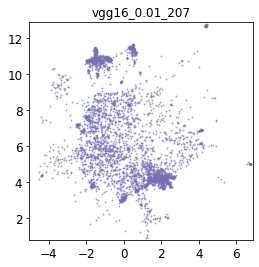

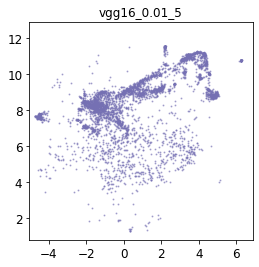

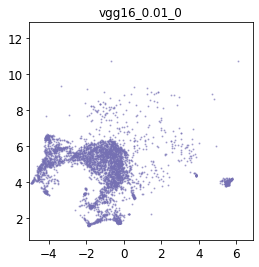

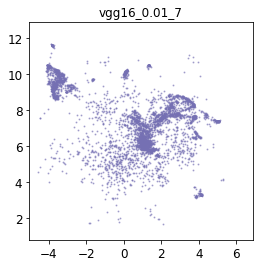

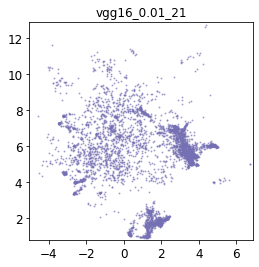

In [34]:
for model_nickname in emb2d:
    Xs = [emb2d[model_nickname][neuron][0] for neuron in emb2d[model_nickname]]
    Ys = [emb2d[model_nickname][neuron][1] for neuron in emb2d[model_nickname]]
    
    plt.figure(figsize=(4, 4))
    plt.scatter(Xs, Ys, s=1, alpha=0.5, c='#7570b3')
    plt.xlim(X_range)
    plt.ylim(Y_range)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(model_nickname)
    plt.savefig(f'{fig_dir}/{model_nickname}.png')
    plt.savefig(f'{fig_dir}/{model_nickname}.svg')
    plt.show()